In [1]:
from myosuite.utils import gym
import skvideo.io
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import os

os.environ['MUJOCO_GL'] = 'egl'

MyoSuite:> Registering Myo Envs


In [2]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width=400):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")


import PIL.Image, PIL.ImageDraw, PIL.ImageFont

def add_text_to_frame(frame, text, font="dejavu/DejaVuSans.ttf", pos=(20, 20), color=(255, 0, 0), fontsize=12):
    if isinstance(frame, np.ndarray):
        frame = PIL.Image.fromarray(frame)
    
    draw = PIL.ImageDraw.Draw(frame)
    draw.text(pos, text, fill=color, font=PIL.ImageFont.truetype(font, fontsize))
    return frame

# Fatigue Modeling

MyoSuite includes a fatigue model based on the (modified) ["Three Compartment Controller (3CC-r)" model](https://doi.org/10.1016/j.jbiomech.2018.06.005). \
The implementation is based on the *CumulativeFatigue* model included in the ["User-in-the-Box" framework](https://github.com/aikkala/user-in-the-box/blob/main/uitb/bm_models/effort_models.py).
For details on the dynamics of the 3CC-r model, we refer the interested readers to the papers from [Looft et al.](https://doi.org/10.1016/j.jbiomech.2018.06.005) and [Cheema et al.](https://doi.org/10.1145/3313831.3376701).

Crucially, the 3CC-r model is implemented on a muscle level, i.e., fatigue is computed for each muscle individually rather than for a single (shoulder) joint. \
While originally built and tested for models of the arm, elbow and hand, it can also be used with models of the lower extremity, e.g., the MyoLeg model.

## Use the Fatigue Model

To model fatigue, load the desired MyoSuite environment in its "Fati" variant:

In [3]:
envFatigue = gym.make('myoFatiElbowPose1D6MRandom-v0', normalize_act=False)

## for comparison
env = gym.make('myoElbowPose1D6MRandom-v0', normalize_act=False)

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


This adds the "muscle_fatigue" attribute, which entails the current fatigue state of each muscle:

In [4]:
envFatigue.muscle_fatigue.MF   #percentage of fatigued motor units for each muscle
envFatigue.muscle_fatigue.MR   #percentage of resting motor units for each muscle
envFatigue.muscle_fatigue.MA   #percentage of active motor units for each muscle

array([0., 0., 0., 0., 0., 0.])

The fatigue/recovery constants F and R as well as the recovery multiplier r, which determines how much faster motor units recover during rest periods (i.e., when less motor units are required than are currently active), can be set using the following methods:

In [5]:
envFatigue.muscle_fatigue.set_RecoveryMultiplier(10)
envFatigue.muscle_fatigue.set_RecoveryCoefficient(0.0022)
envFatigue.muscle_fatigue.set_FatigueCoefficient(0.0146)

envFatigue.muscle_fatigue.r, envFatigue.muscle_fatigue.R, envFatigue.muscle_fatigue.F

(10, 0.0022, 0.0146)

The muscle force development/relaxation factors LD and LR are automatically computed for each muscle based on its time activation and deactivation constants.

#### Initial Fatigue States

By default, the distribution of fatigued, resting and active motor units is randomly chosen at the beginning of each episode.
During training, this helps the agent learning to deal with different levels of fatigue, resulting in a more robust control strategy.

In [6]:
envFatigue.reset()
envFatigue.muscle_fatigue.MF, envFatigue.muscle_fatigue.MR, envFatigue.muscle_fatigue.MA

(array([0.7229, 0.9829, 0.3452, 0.1068, 0.0471, 0.9506]),
 array([0.1633, 0.0098, 0.4351, 0.0728, 0.537 , 0.0384]),
 array([0.1139, 0.0073, 0.2198, 0.8205, 0.4159, 0.0111]))

To reset to the default "non-fatigued" muscle state with 100% resting motor units, use the following command:

In [7]:
envFatigue.set_fatigue_reset_random(False)

envFatigue.reset()
envFatigue.muscle_fatigue.MF, envFatigue.muscle_fatigue.MR, envFatigue.muscle_fatigue.MA

(array([0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0.]))

In the fatigue variant, the simulation applies the "currently available" muscle controls as defined by the fatigue state and dynamics, rather than the intended muscle control signals a:

In [8]:
a = np.zeros(envFatigue.sim.model.na,)
a[0] = 1

envFatigue.reset()
for i in range(10):
    next_o, r, done, *_, ifo = envFatigue.step(a) # take an action

# Comparison: without fatigue
env.reset()
for i in range(10):
    next_o, r, done, *_, ifo = env.step(a) # take an action

env.last_ctrl, envFatigue.last_ctrl, envFatigue.muscle_fatigue.MF

(array([1., 0., 0., 0., 0., 0.]),
 array([0.9974, 0.    , 0.    , 0.    , 0.    , 0.    ]),
 array([0.0026, 0.    , 0.    , 0.    , 0.    , 0.    ]))

This allows to predict how fatigue evolves over time:

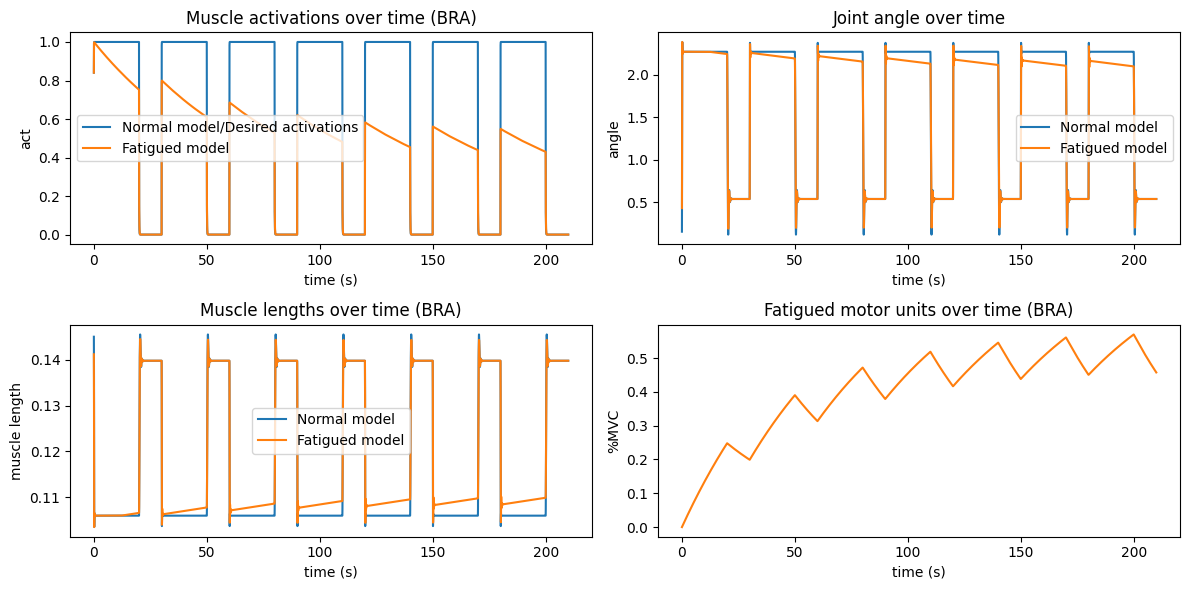

In [9]:
env.reset()
envFatigue.reset()
data_store = []
data_store_f = []
for i in range(7*3): # 7 batches of 3 episodes, with 2 episodes of maximum muscle controls for some muscles followed by a resting episode (i.e., zero muscle controls) in each batch
    a = np.zeros(env.sim.model.na,)
    if i%3!=2:
        a[3:]=1
    else:
        a[:]=0
    
    for _ in range(500): # 500 samples (=10s) for each episode
        next_o, r, done, *_, ifo = env.step(a) # take an action
        next_f_o, r_f, done_F, *_, ifo_f = envFatigue.step(a) # take an action
                    
        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy()})
        data_store_f.append({"action":a.copy(), 
                            "jpos":envFatigue.sim.data.qpos.copy(), 
                            "mlen":envFatigue.sim.data.actuator_length.copy(),
                            "MF":envFatigue.muscle_fatigue.MF.copy(),
                            "MR":envFatigue.muscle_fatigue.MR.copy(),
                            "MA":envFatigue.muscle_fatigue.MA.copy(), 
                            "act":envFatigue.sim.data.act.copy()})

env.close()
envFatigue.close()

muscle_names = [env.sim.model.id2name(i, "actuator") for i in range(env.sim.model.na)]
muscle_id = -1

plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]), label="Normal model/Desired activations")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store_f]), label='Fatigued model')
plt.legend()
plt.title(f'Muscle activations over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('act')

plt.subplot(222)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['jpos'] for d in data_store]), label="Normal model")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['jpos'] for d in data_store_f]), label="Fatigued model")
plt.legend()
plt.title('Joint angle over time')
plt.xlabel('time (s)'),plt.ylabel('angle')

plt.subplot(223)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['mlen'][muscle_id] for d in data_store]), label="Normal model")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['mlen'][muscle_id] for d in data_store_f]), label="Fatigued model")
plt.legend()
plt.title(f'Muscle lengths over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('muscle length')

plt.subplot(224)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['MF'][muscle_id] for d in data_store_f]), color="tab:orange")
plt.title(f'Fatigued motor units over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('%MVC')

plt.tight_layout()
plt.show()

# plt.subplot(212),plt.plot(np.array([d['jpos'] for d in data_store])-np.array([d['jpos'] for d in data_store_f]), color="black")
# plt.xlabel('time'),plt.ylabel('angle difference')
# plt.title('Difference between normal vs. fatigued')

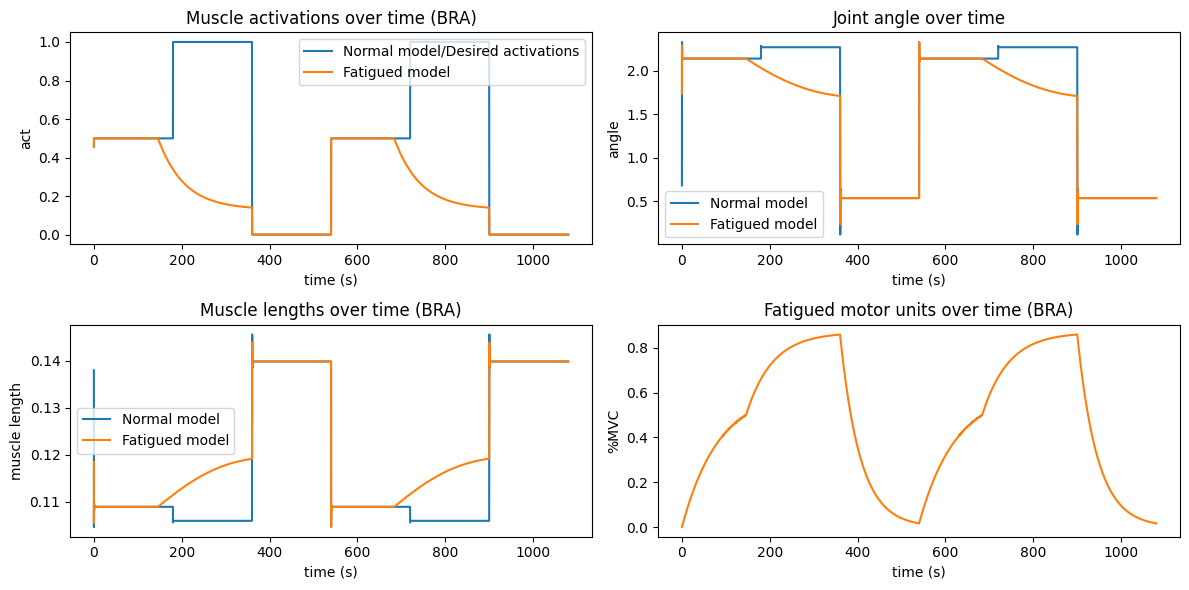

In [10]:
env.reset()
envFatigue.reset()
data_store = []
data_store_f = []
for i in range(2*3): # 2 batches of 3 episodes, with 0.5*MVC in first and 1*MVC in second episode, followed by a resting episode (i.e., zero muscle controls) in each batch
    a = np.zeros(env.sim.model.na,)
    if i%3==0:
        a[3:]=0.5
    elif i%3==1:
        a[3:]=1
    else:
        a[:]=0
    
    for _ in range(9000): # 9000 samples (=3 minutes) for each episode
        next_o, r, done, *_, ifo = env.step(a) # take an action
        next_f_o, r_f, done_F, *_, ifo_f = envFatigue.step(a) # take an action
                    
        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy()})
        data_store_f.append({"action":a.copy(), 
                            "jpos":envFatigue.sim.data.qpos.copy(), 
                            "mlen":envFatigue.sim.data.actuator_length.copy(),
                            "MF":envFatigue.muscle_fatigue.MF.copy(),
                            "MR":envFatigue.muscle_fatigue.MR.copy(),
                            "MA":envFatigue.muscle_fatigue.MA.copy(),
                            "act":envFatigue.sim.data.act.copy()})

env.close()
envFatigue.close()

muscle_names = [env.sim.model.id2name(i, "actuator") for i in range(env.sim.model.na)]
muscle_id = -1

plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]), label="Normal model/Desired activations")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store_f]), label='Fatigued model')
plt.legend()
plt.title(f'Muscle activations over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('act')

plt.subplot(222)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['jpos'] for d in data_store]), label="Normal model")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['jpos'] for d in data_store_f]), label="Fatigued model")
plt.legend()
plt.title('Joint angle over time')
plt.xlabel('time (s)'),plt.ylabel('angle')

plt.subplot(223)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['mlen'][muscle_id] for d in data_store]), label="Normal model")
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['mlen'][muscle_id] for d in data_store_f]), label="Fatigued model")
plt.legend()
plt.title(f'Muscle lengths over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('muscle length')

plt.subplot(224)
plt.plot(env.dt*np.arange(len(data_store)), np.array([d['MF'][muscle_id] for d in data_store_f]), color="tab:orange")
plt.title(f'Fatigued motor units over time ({muscle_names[muscle_id]})')
plt.xlabel('time (s)'),plt.ylabel('%MVC')

plt.tight_layout()
plt.show()

## Train Agents with Fatigue

**NOTE:** By default, random fatigue states are sampled at the beginning of each training episode. \
To start with a specific, fixed fatigue state, set `fatigue_reset_random=False` and define `fatigue_reset_vec` as the vector MF of fatigued motor units per muscle.

Best practice is to create a new  of the desired environment, i.e., calling `register_env_variant()` with
`variants={'muscle_condition': 'fatigue',
            'fatigue_reset_vec': np.array([0., 0., 0.]),
            'fatigue_reset_random': False}`.


In [56]:
from mjrl.utils.gym_env import GymEnv
from mjrl.policies.gaussian_mlp import MLP
from mjrl.baselines.mlp_baseline import MLPBaseline
from mjrl.algos.npg_cg import NPG
from mjrl.utils.train_agent import train_agent

### Example 1: ElbowPose1D6M

In [ ]:
env_name = "myoFatiElbowPose1D6MRandom-v0"

env = gym.make(env_name)
env.reset()
    
policy_size = (32, 32)
vf_hidden_size = (128, 128)
seed = 123
rl_step_size = 0.1
e = GymEnv(env)

policy = MLP(e.spec, hidden_sizes=policy_size, seed=seed, init_log_std=-0.25, min_log_std=-1.0)

baseline = MLPBaseline(e.spec, reg_coef=1e-3, batch_size=64, hidden_sizes=vf_hidden_size, \
                    epochs=2, use_gpu=True, learn_rate=1e-3)

agent = NPG(e, policy, baseline, normalized_step_size=rl_step_size, \
            seed=seed, save_logs=True)

print("========================================")
print("Starting policy learning")
print("========================================")

train_agent(job_name=f'./{env_name}',
            agent=agent,
            seed=seed,
            niter=200000,
            gamma=0.995,
            gae_lambda=0.97,
            num_cpu=8,
            sample_mode="trajectories",
            num_traj=96,
            num_samples=0,
            save_freq=500,
            evaluation_rollouts=10)

print("========================================")
print("Job Finished.") 
print("========================================")

### Example 2: HandObjHold

In [ ]:
env_name = 'myoFatiHandObjHoldFixed-v0'

env = gym.make(env_name)
env.reset()
    
policy_size = (32, 32)
vf_hidden_size = (128, 128)
seed = 123
rl_step_size = 0.1
e = GymEnv(env)

policy = MLP(e.spec, hidden_sizes=policy_size, seed=seed, init_log_std=-0.25, min_log_std=-1.0)

baseline = MLPBaseline(e.spec, reg_coef=1e-3, batch_size=64, hidden_sizes=vf_hidden_size, \
                    epochs=2, use_gpu=True, learn_rate=1e-3)

agent = NPG(e, policy, baseline, normalized_step_size=rl_step_size, \
            seed=seed, save_logs=True)

print("========================================")
print("Starting policy learning")
print("========================================")

train_agent(job_name=f'./{env_name}',
            agent=agent,
            seed=seed,
            niter=200000,
            gamma=0.995,
            gae_lambda=0.97,
            num_cpu=8,
            sample_mode="trajectories",
            num_traj=96,
            num_samples=0,
            save_freq=500,
            evaluation_rollouts=10)

print("========================================")
print("Job Finished.") 
print("========================================")

## Simulate and Evaluate Trained Agents

In the following, we evaluate the latest policy trained for a given fatigue environment (and for comparison also the policy trained in the respective non-fatigue environment).

To this end, we simulate 1000 episodes per policy, with fatigue accumulating across episodes, starting in the default zero fatigue state. \
Videos of the first and the last episodes are generated, and simulation data is logged (and later visualised) for all episodes.

### Example 1: ElbowPose1D6M

In [11]:
env_name = "myoFatiElbowPose1D6MRandom-v0"

GENERATE_VIDEO = True
GENERATE_VIDEO_EPS = 4  #number of episodes that are rendered BOTH at the beginning (i.e., without fatigue) and at the end (i.e., with fatigue)

STORE_DATA = True  #store collected data from evaluation run in .npy file
n_eps = 1000  #500

###################################

env = gym.make(env_name)

policy = f"{env_name}/iterations/best_policy.pickle"
pi = pickle.load(open(policy, 'rb'))

env.set_fatigue_reset_random(False)
env.reset(fatigue_reset=True)  #ensure that fatigue is reset before the simulation starts

data_store = []
if GENERATE_VIDEO:
    frames = []

target_jnt_value_cycle = env.target_jnt_range.T  #required for Pose tasks only
start_time = time.time()
for ep in range(n_eps):
    if ep%10==0:
        print("Ep {} of {}".format(ep, n_eps))
    
    #required for Pose tasks only:
    env.env.target_jnt_value = target_jnt_value_cycle[ep%len(target_jnt_value_cycle)]
    env.env.target_type = 'fixed'
    env.env.weight_range=(0,0)  #TODO: remove this line?
    env.env.update_target(restore_sim=True)  #only update target posture, do not reset fatigue model at each episode

    for _cstep in range(env.spec.max_episode_steps):  #40):
        if GENERATE_VIDEO and (ep in range(GENERATE_VIDEO_EPS)) or (ep in range(n_eps-GENERATE_VIDEO_EPS, n_eps)):
            frame = env.sim.renderer.render_offscreen(width=400, height=400, camera_id=3)
            
            # Add text overlay
            _current_time = (ep*env.spec.max_episode_steps + _cstep)*env.dt
            frame = np.array(add_text_to_frame(frame,
                    f"t={str(int(_current_time//60)).zfill(2)}:{str(int(_current_time%60)).zfill(2)}m",
                    pos=(5, 5), color=(0, 0, 0), fontsize=18))
            
            frames.append(frame)
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, ifo = env.step(a) # take an action based on the current observation
        # if done:
        #     print((_, env.rwd_dict))

        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy(),
                            "reward":r,
                            # "rwd_dict":env.rwd_dict,
                            "solved":env.rwd_dict['solved'].item(),
                            "pose_err":env.get_obs_dict(env.sim)["pose_err"],
                            "MA":env.muscle_fatigue.MA.copy(),
                            "MR":env.muscle_fatigue.MR.copy(),
                            "MF":env.muscle_fatigue.MF.copy(),
                            "ctrl":env.last_ctrl.copy()})
env.close()

## OPTIONALLY: Stored simulated data
if STORE_DATA:
    os.makedirs(f"{env_name}/logs", exist_ok=True)
    np.save(f"{env_name}/logs/fatitest.npy", data_store)

## OPTIONALLY: Render video
if GENERATE_VIDEO:
    os.makedirs(f'{env_name}/videos', exist_ok=True)
    # make a local copy
    skvideo.io.vwrite(f'{env_name}/videos/fatitest.mp4', np.asarray(frames),inputdict={'-r': str(int(1/env.dt))},outputdict={"-pix_fmt": "yuv420p"})

end_time = time.time()
print(f"DURATION: {end_time - start_time:.2f}s")

if GENERATE_VIDEO:
    display(show_video(f'{env_name}/videos/fatitest.mp4'))

Ep 0 of 1000
Ep 10 of 1000
Ep 20 of 1000
Ep 30 of 1000
Ep 40 of 1000
Ep 50 of 1000
Ep 60 of 1000
Ep 70 of 1000
Ep 80 of 1000
Ep 90 of 1000
Ep 100 of 1000
Ep 110 of 1000
Ep 120 of 1000
Ep 130 of 1000
Ep 140 of 1000
Ep 150 of 1000
Ep 160 of 1000
Ep 170 of 1000
Ep 180 of 1000
Ep 190 of 1000
Ep 200 of 1000
Ep 210 of 1000
Ep 220 of 1000
Ep 230 of 1000
Ep 240 of 1000
Ep 250 of 1000
Ep 260 of 1000
Ep 270 of 1000
Ep 280 of 1000
Ep 290 of 1000
Ep 300 of 1000
Ep 310 of 1000
Ep 320 of 1000
Ep 330 of 1000
Ep 340 of 1000
Ep 350 of 1000
Ep 360 of 1000
Ep 370 of 1000
Ep 380 of 1000
Ep 390 of 1000
Ep 400 of 1000
Ep 410 of 1000
Ep 420 of 1000
Ep 430 of 1000
Ep 440 of 1000
Ep 450 of 1000
Ep 460 of 1000
Ep 470 of 1000
Ep 480 of 1000
Ep 490 of 1000
Ep 500 of 1000
Ep 510 of 1000
Ep 520 of 1000
Ep 530 of 1000
Ep 540 of 1000
Ep 550 of 1000
Ep 560 of 1000
Ep 570 of 1000
Ep 580 of 1000
Ep 590 of 1000
Ep 600 of 1000
Ep 610 of 1000
Ep 620 of 1000
Ep 630 of 1000
Ep 640 of 1000
Ep 650 of 1000
Ep 660 of 1000
Ep 670

Muscle Fatigue Equilibrium: [0.0194 0.0818 0.0565 0.3102 0.2694 0.1873]


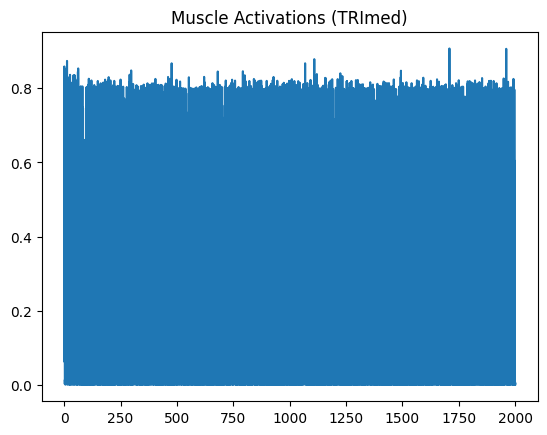

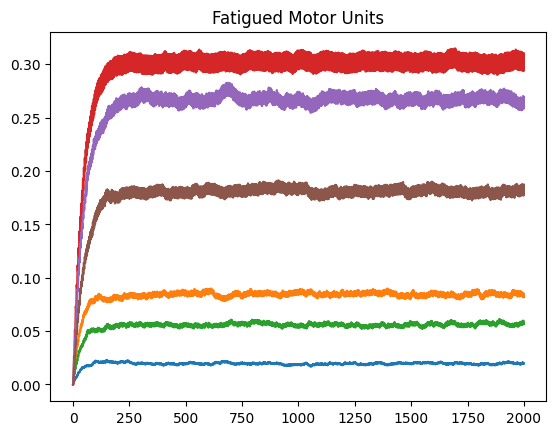

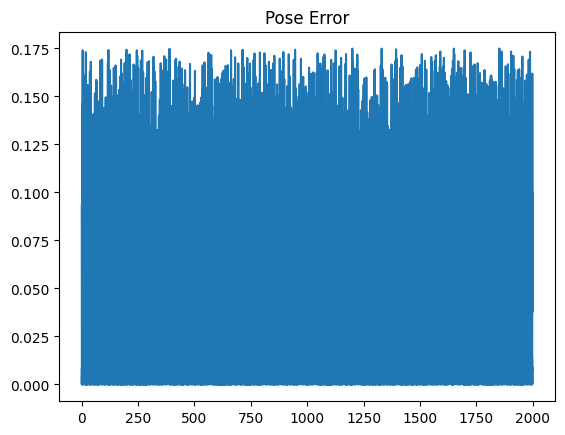

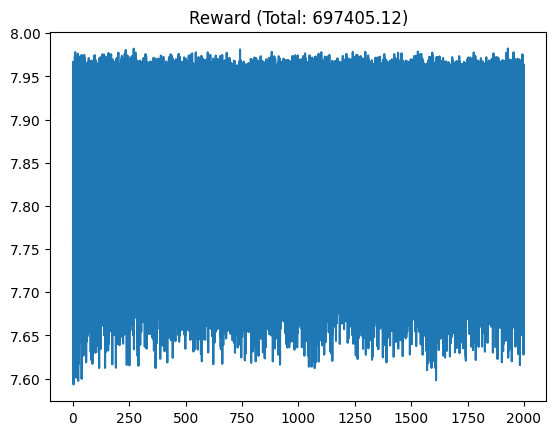

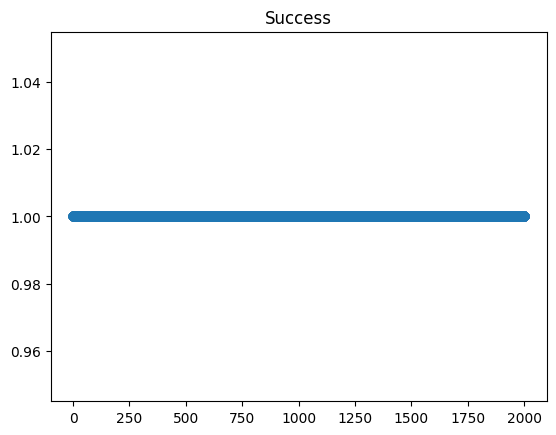

In [14]:
env_name = "myoFatiElbowPose1D6MRandom-v0"
muscle_id = 2

####################

env_test = gym.make(env_name, normalize_act=False)
muscle_names = [env_test.sim.model.id2name(i, "actuator") for i in range(env_test.sim.model.na)]
_env_dt = env_test.dt  #0.02

data_store = np.load(f"{env_name}/logs/fatitest.npy", allow_pickle=True)

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['act'][muscle_id] for d in data_store])[np.array([d['solved'] for d in data_store])])
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]))
plt.title(f'Muscle Activations ({muscle_names[muscle_id]})')

plt.figure()
for _muscleid in range(len(data_store[0]['MF'])):
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['MF'][_muscleid] for d in data_store]))
plt.title('Fatigued Motor Units')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([np.linalg.norm(d['pose_err']) for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title('Pose Error')
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([np.linalg.norm(d['pose_err']) for d in data_store])), plt.title('Pose Error')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['reward'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['reward'] for d in data_store])), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")

if "solved" in data_store[0]:
    plt.figure()
    plt.scatter(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['solved'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Success")

print(f"Muscle Fatigue Equilibrium: {data_store[-1]['MF']}")

Comparison: Policy trained without fatigue

In [15]:
env_name = "myoFatiElbowPose1D6MRandom-v0"

GENERATE_VIDEO = True
GENERATE_VIDEO_EPS = 4  #number of episodes that are rendered BOTH at the beginning (i.e., without fatigue) and at the end (i.e., with fatigue)

STORE_DATA = True  #store collected data from evaluation run in .npy file
n_eps = 1000  #500

###################################

env = gym.make(env_name)

policy = "../../../myosuite/agents/baslines_NPG/myoElbowPose1D6MRandom-v0/2022-02-26_21-16-27/33_env=myoElbowPose1D6MRandom-v0,seed=1/iterations/best_policy.pickle"
pi = pickle.load(open(policy, 'rb'))

env.set_fatigue_reset_random(False)
env.reset(fatigue_reset=True)  #ensure that fatigue is reset before the simulation starts

data_store = []
if GENERATE_VIDEO:
    frames = []

target_jnt_value_cycle = env.target_jnt_range.T
start_time = time.time()
for ep in range(n_eps):
    if ep%10==0:
        print("Ep {} of {}".format(ep, n_eps))
        
    env.env.target_jnt_value = target_jnt_value_cycle[ep%len(target_jnt_value_cycle)]
    env.env.target_type = 'fixed'
    env.env.weight_range=(0,0)  #TODO: remove this line?
    env.env.update_target(restore_sim=True)  #only update target posture, do not reset fatigue model at each episode

    for _cstep in range(env.spec.max_episode_steps):  #40):
        if GENERATE_VIDEO and (ep in range(GENERATE_VIDEO_EPS)) or (ep in range(n_eps-GENERATE_VIDEO_EPS, n_eps)):
            frame = env.sim.renderer.render_offscreen(width=400, height=400, camera_id=3)
            
            # Add text overlay
            _current_time = (ep*env.spec.max_episode_steps + _cstep)*env.dt
            frame = np.array(add_text_to_frame(frame,
                    f"t={str(int(_current_time//60)).zfill(2)}:{str(int(_current_time%60)).zfill(2)}m",
                    pos=(5, 5), color=(0, 0, 0), fontsize=18))
            
            frames.append(frame)
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, ifo = env.step(a) # take an action based on the current observation
        # if done:
        #     print((_, env.rwd_dict))

        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy(),
                            "reward":r,
                            # "rwd_dict":env.rwd_dict,
                            "solved":env.rwd_dict['solved'].item(),
                            "pose_err":env.get_obs_dict(env.sim)["pose_err"],
                            "MA":env.muscle_fatigue.MA.copy(),
                            "MR":env.muscle_fatigue.MR.copy(),
                            "MF":env.muscle_fatigue.MF.copy(),
                            "ctrl":env.last_ctrl.copy()})
env.close()

## OPTIONALLY: Stored simulated data
if STORE_DATA:
    os.makedirs(f"{env_name}/logs", exist_ok=True)
    np.save(f"{env_name}/logs/fatitest_trained_wo_fatigue.npy", data_store)

## OPTIONALLY: Render video
if GENERATE_VIDEO:
    os.makedirs(f'{env_name}/videos', exist_ok=True)
    # make a local copy
    skvideo.io.vwrite(f'{env_name}/videos/fatitest_trained_wo_fatigue.mp4', np.asarray(frames),inputdict={'-r': str(int(1/env.dt))},outputdict={"-pix_fmt": "yuv420p"})

end_time = time.time()
print(f"DURATION: {end_time - start_time:.2f}s")

if GENERATE_VIDEO:
    display(show_video(f'{env_name}/videos/fatitest_trained_wo_fatigue.mp4'))

Ep 0 of 1000
Ep 10 of 1000
Ep 20 of 1000
Ep 30 of 1000
Ep 40 of 1000
Ep 50 of 1000
Ep 60 of 1000
Ep 70 of 1000
Ep 80 of 1000
Ep 90 of 1000
Ep 100 of 1000
Ep 110 of 1000
Ep 120 of 1000
Ep 130 of 1000
Ep 140 of 1000
Ep 150 of 1000
Ep 160 of 1000
Ep 170 of 1000
Ep 180 of 1000
Ep 190 of 1000
Ep 200 of 1000
Ep 210 of 1000
Ep 220 of 1000
Ep 230 of 1000
Ep 240 of 1000
Ep 250 of 1000
Ep 260 of 1000
Ep 270 of 1000
Ep 280 of 1000
Ep 290 of 1000
Ep 300 of 1000
Ep 310 of 1000
Ep 320 of 1000
Ep 330 of 1000
Ep 340 of 1000
Ep 350 of 1000
Ep 360 of 1000
Ep 370 of 1000
Ep 380 of 1000
Ep 390 of 1000
Ep 400 of 1000
Ep 410 of 1000
Ep 420 of 1000
Ep 430 of 1000
Ep 440 of 1000
Ep 450 of 1000
Ep 460 of 1000
Ep 470 of 1000
Ep 480 of 1000
Ep 490 of 1000
Ep 500 of 1000
Ep 510 of 1000
Ep 520 of 1000
Ep 530 of 1000
Ep 540 of 1000
Ep 550 of 1000
Ep 560 of 1000
Ep 570 of 1000
Ep 580 of 1000
Ep 590 of 1000
Ep 600 of 1000
Ep 610 of 1000
Ep 620 of 1000
Ep 630 of 1000
Ep 640 of 1000
Ep 650 of 1000
Ep 660 of 1000
Ep 670

Muscle Fatigue Equilibrium: [0.0484 0.0233 0.041  0.2765 0.083  0.3025]


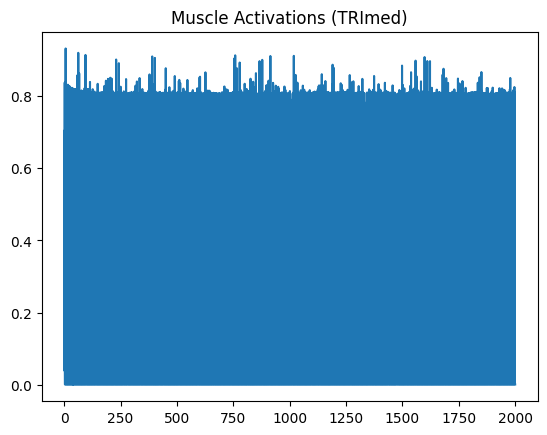

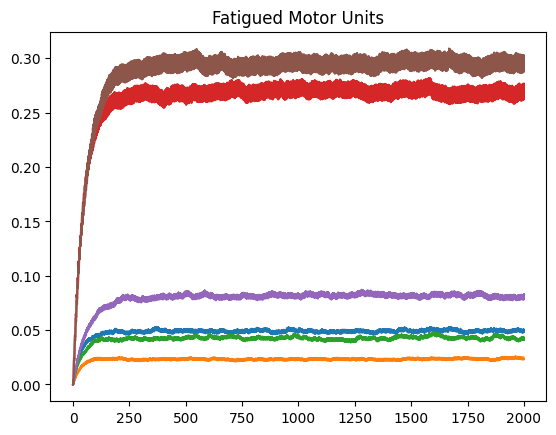

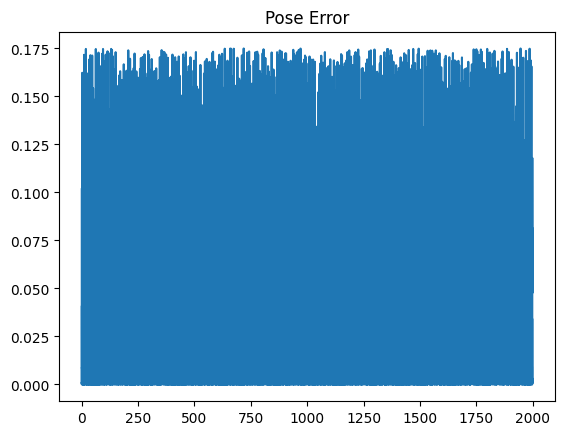

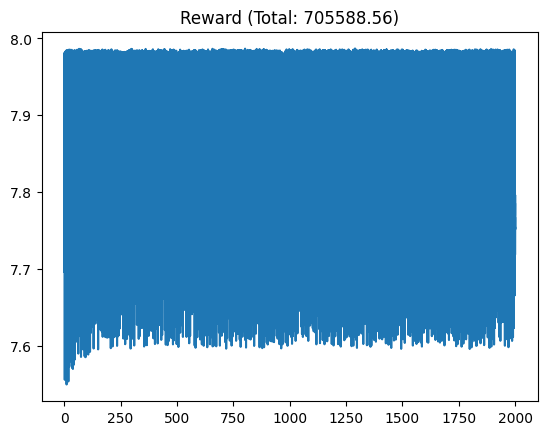

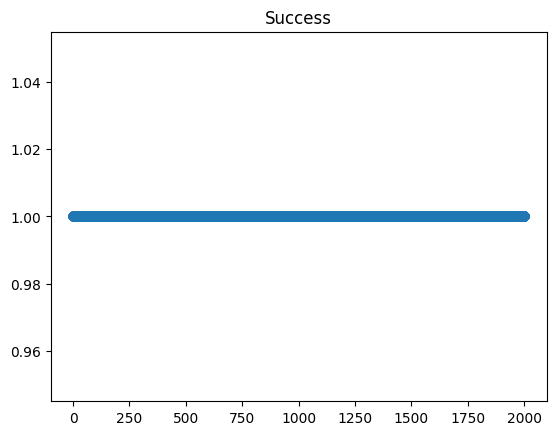

In [17]:
env_name = "myoFatiElbowPose1D6MRandom-v0"
muscle_id = 2

####################

env_test = gym.make(env_name, normalize_act=False)
muscle_names = [env_test.sim.model.id2name(i, "actuator") for i in range(env_test.sim.model.na)]
_env_dt = env_test.dt  #0.02

data_store = np.load(f"{env_name}/logs/fatitest_trained_wo_fatigue.npy", allow_pickle=True)

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['act'][muscle_id] for d in data_store])[np.array([d['solved'] for d in data_store])])
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]))
plt.title(f'Muscle Activations ({muscle_names[muscle_id]})')

plt.figure()
for _muscleid in range(len(data_store[0]['MF'])):
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['MF'][_muscleid] for d in data_store]))
plt.title('Fatigued Motor Units')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([np.linalg.norm(d['pose_err']) for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title('Pose Error')
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([np.linalg.norm(d['pose_err']) for d in data_store])), plt.title('Pose Error')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['reward'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['reward'] for d in data_store])), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")

if "solved" in data_store[0]:
    plt.figure()
    plt.scatter(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['solved'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Success")

print(f"Muscle Fatigue Equilibrium: {data_store[-1]['MF']}")

### Example 2: HandObjHold

In [18]:
env_name = "myoFatiHandObjHoldFixed-v0"

GENERATE_VIDEO = True
GENERATE_VIDEO_EPS = 4  #number of episodes that are rendered BOTH at the beginning (i.e., without fatigue) and at the end (i.e., with fatigue)

STORE_DATA = True  #store collected data from evaluation run in .npy file
n_eps = 1000  #500

###################################

env = gym.make(env_name)

policy = f"{env_name}/iterations/best_policy.pickle"
pi = pickle.load(open(policy, 'rb'))

env.set_fatigue_reset_random(False)
env.reset(fatigue_reset=True)  #ensure that fatigue is reset before the simulation starts

data_store = []
if GENERATE_VIDEO:
    frames = []

start_time = time.time()
for ep in range(n_eps):
    if ep%10==0:
        print("Ep {} of {}".format(ep, n_eps))

    env.reset(fatigue_reset=False)  #required for fixed tasks to ensure that body posture is reset at the beginning of each episode (but not the fatigue state!)

    for _cstep in range(env.spec.max_episode_steps):  #40):
        if GENERATE_VIDEO and (ep in range(GENERATE_VIDEO_EPS)) or (ep in range(n_eps-GENERATE_VIDEO_EPS, n_eps)):
            frame = env.sim.renderer.render_offscreen(width=400, height=400, camera_id=3)
            
            # Add text overlay
            _current_time = (ep*env.spec.max_episode_steps + _cstep)*env.dt
            frame = np.array(add_text_to_frame(frame,
                    f"t={str(int(_current_time//60)).zfill(2)}:{str(int(_current_time%60)).zfill(2)}m",
                    pos=(5, 5), color=(0, 0, 0), fontsize=18))
            
            frames.append(frame)
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, ifo = env.step(a) # take an action based on the current observation
        # if done:
        #     print((_, env.rwd_dict))

        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy(),
                            "reward":r,
                            # "rwd_dict":env.rwd_dict,
                            "solved":env.rwd_dict['solved'].item(),
                            "obj_err":env.get_obs_dict(env.sim)["obj_err"],
                            "MA":env.muscle_fatigue.MA.copy(),
                            "MR":env.muscle_fatigue.MR.copy(),
                            "MF":env.muscle_fatigue.MF.copy(),
                            "ctrl":env.last_ctrl.copy()})
env.close()

## OPTIONALLY: Stored simulated data
if STORE_DATA:
    os.makedirs(f"{env_name}/logs", exist_ok=True)
    np.save(f"{env_name}/logs/fatitest.npy", data_store)

## OPTIONALLY: Render video
if GENERATE_VIDEO:
    os.makedirs(f'{env_name}/videos', exist_ok=True)
    # make a local copy
    skvideo.io.vwrite(f'{env_name}/videos/fatitest.mp4', np.asarray(frames),inputdict={'-r': str(int(1/env.dt))},outputdict={"-pix_fmt": "yuv420p"})

end_time = time.time()
print(f"DURATION: {end_time - start_time:.2f}s")

if GENERATE_VIDEO:
    display(show_video(f'{env_name}/videos/fatitest.mp4'))

Ep 0 of 1000
Ep 10 of 1000
Ep 20 of 1000
Ep 30 of 1000
Ep 40 of 1000
Ep 50 of 1000
Ep 60 of 1000
Ep 70 of 1000
Ep 80 of 1000
Ep 90 of 1000
Ep 100 of 1000
Ep 110 of 1000
Ep 120 of 1000
Ep 130 of 1000
Ep 140 of 1000
Ep 150 of 1000
Ep 160 of 1000
Ep 170 of 1000
Ep 180 of 1000
Ep 190 of 1000
Ep 200 of 1000
Ep 210 of 1000
Ep 220 of 1000
Ep 230 of 1000
Ep 240 of 1000
Ep 250 of 1000
Ep 260 of 1000
Ep 270 of 1000
Ep 280 of 1000
Ep 290 of 1000
Ep 300 of 1000
Ep 310 of 1000
Ep 320 of 1000
Ep 330 of 1000
Ep 340 of 1000
Ep 350 of 1000
Ep 360 of 1000
Ep 370 of 1000
Ep 380 of 1000
Ep 390 of 1000
Ep 400 of 1000
Ep 410 of 1000
Ep 420 of 1000
Ep 430 of 1000
Ep 440 of 1000
Ep 450 of 1000
Ep 460 of 1000
Ep 470 of 1000
Ep 480 of 1000
Ep 490 of 1000
Ep 500 of 1000
Ep 510 of 1000
Ep 520 of 1000
Ep 530 of 1000
Ep 540 of 1000
Ep 550 of 1000
Ep 560 of 1000
Ep 570 of 1000
Ep 580 of 1000
Ep 590 of 1000
Ep 600 of 1000
Ep 610 of 1000
Ep 620 of 1000
Ep 630 of 1000
Ep 640 of 1000
Ep 650 of 1000
Ep 660 of 1000
Ep 670

Muscle Fatigue Equilibrium: [8.6902e-01 5.1569e-02 2.8297e-05 1.9679e-02 6.6397e-04 2.1182e-01
 3.0576e-04 4.8429e-03 2.8181e-03 8.4521e-04 7.0778e-04 2.4098e-04
 5.7552e-04 2.4146e-04 8.2790e-04 1.0522e-03 4.3053e-03 5.4698e-02
 9.5176e-02 7.7370e-03 5.0998e-02 5.2928e-02 2.2384e-02 1.1863e-02
 8.1276e-04 2.7781e-04 1.1389e-01 1.8174e-02 7.6062e-02 2.7041e-03
 2.7926e-02 4.8257e-02 1.1997e-03 9.5490e-03 2.5675e-02 6.9997e-03
 3.2572e-01 1.4865e-02 4.9575e-04]


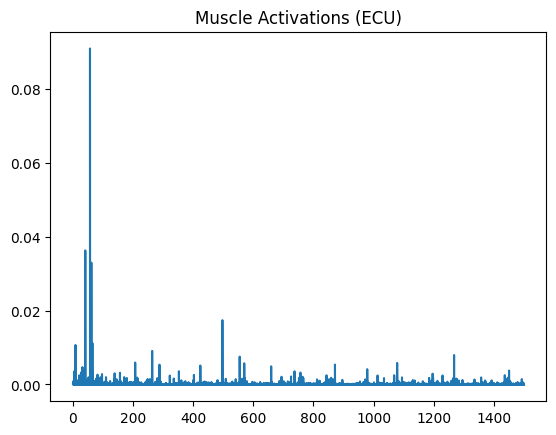

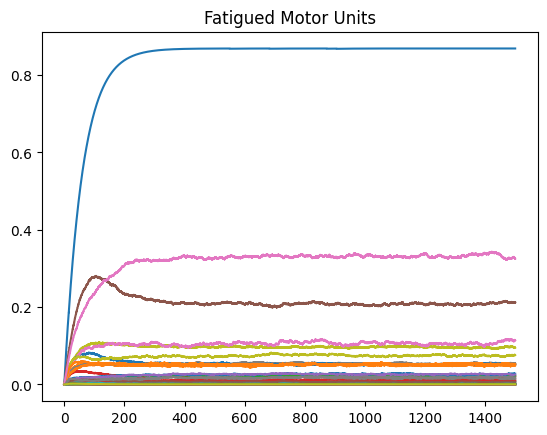

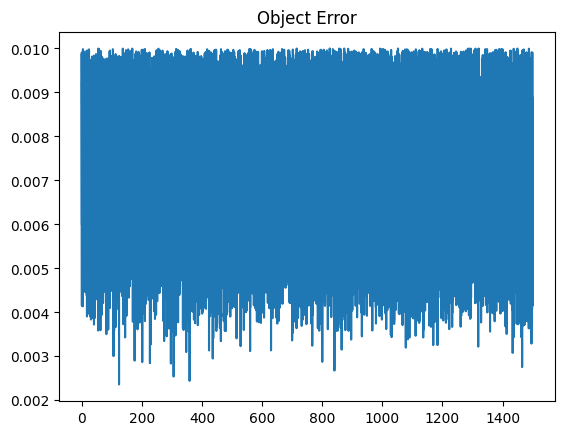

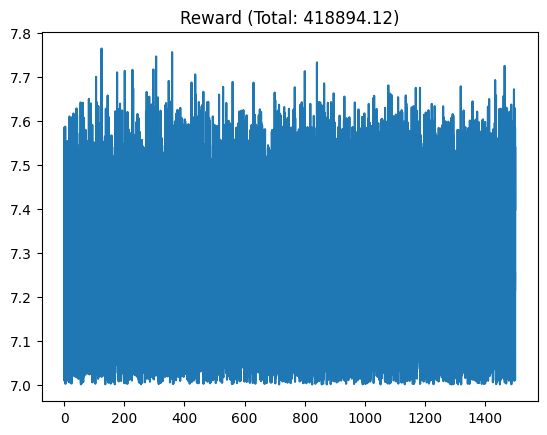

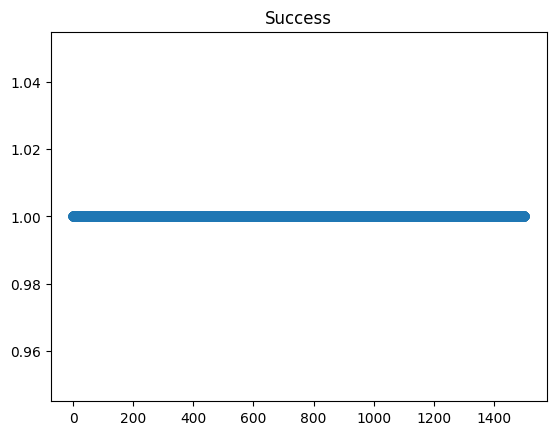

In [19]:
env_name = "myoFatiHandObjHoldFixed-v0"
muscle_id = 2

####################

env_test = gym.make(env_name, normalize_act=False)
muscle_names = [env_test.sim.model.id2name(i, "actuator") for i in range(env_test.sim.model.na)]
_env_dt = env_test.dt  #0.02

data_store = np.load(f"{env_name}/logs/fatitest.npy", allow_pickle=True)

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['act'][muscle_id] for d in data_store])[np.array([d['solved'] for d in data_store])])
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]))
plt.title(f'Muscle Activations ({muscle_names[muscle_id]})')

plt.figure()
for _muscleid in range(len(data_store[0]['MF'])):
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['MF'][_muscleid] for d in data_store]))
plt.title('Fatigued Motor Units')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([np.linalg.norm(d['obj_err']) for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title('Object Error')
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([np.linalg.norm(d['obj_err']) for d in data_store])), plt.title('Object Error')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['reward'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['reward'] for d in data_store])), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")

if "solved" in data_store[0]:
    plt.figure()
    plt.scatter(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['solved'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Success")

print(f"Muscle Fatigue Equilibrium: {data_store[-1]['MF']}")

Comparison: Policy trained without fatigue

In [20]:
env_name = "myoFatiHandObjHoldFixed-v0"

GENERATE_VIDEO = True
GENERATE_VIDEO_EPS = 4  #number of episodes that are rendered BOTH at the beginning (i.e., without fatigue) and at the end (i.e., with fatigue)

STORE_DATA = True  #store collected data from evaluation run in .npy file
n_eps = 1000  #500

###################################

env = gym.make(env_name)

policy = "../../../myosuite/agents/baslines_NPG/myoHandObjHoldFixed-v0/2022-02-27_11-03-32/18_env=myoHandObjHoldFixed-v0,seed=1/iterations/best_policy.pickle"
pi = pickle.load(open(policy, 'rb'))

env.set_fatigue_reset_random(False)
env.reset(fatigue_reset=True)  #ensure that fatigue is reset before the simulation starts

data_store = []
if GENERATE_VIDEO:
    frames = []

start_time = time.time()
for ep in range(n_eps):
    if ep%10==0:
        print("Ep {} of {}".format(ep, n_eps))

    env.reset(fatigue_reset=False)  #required for fixed tasks to ensure that body posture is reset at the beginning of each episode (but not the fatigue state!)

    for _cstep in range(env.spec.max_episode_steps):  #40):
        if GENERATE_VIDEO and (ep in range(GENERATE_VIDEO_EPS)) or (ep in range(n_eps-GENERATE_VIDEO_EPS, n_eps)):
            frame = env.sim.renderer.render_offscreen(width=400, height=400, camera_id=3)
            
            # Add text overlay
            _current_time = (ep*env.spec.max_episode_steps + _cstep)*env.dt
            frame = np.array(add_text_to_frame(frame,
                    f"t={str(int(_current_time//60)).zfill(2)}:{str(int(_current_time%60)).zfill(2)}m",
                    pos=(5, 5), color=(0, 0, 0), fontsize=18))
            
            frames.append(frame)
        o = env.get_obs()
        a = pi.get_action(o)[0]
        next_o, r, done, ifo = env.step(a) # take an action based on the current observation
        # if done:
        #     print((_, env.rwd_dict))

        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy(),
                            "reward":r,
                            # "rwd_dict":env.rwd_dict,
                            "solved":env.rwd_dict['solved'].item(),
                            "obj_err":env.get_obs_dict(env.sim)["obj_err"],
                            "MA":env.muscle_fatigue.MA.copy(),
                            "MR":env.muscle_fatigue.MR.copy(),
                            "MF":env.muscle_fatigue.MF.copy(),
                            "ctrl":env.last_ctrl.copy()})
env.close()

## OPTIONALLY: Stored simulated data
if STORE_DATA:
    os.makedirs(f"{env_name}/logs", exist_ok=True)
    np.save(f"{env_name}/logs/fatitest_trained_wo_fatigue.npy", data_store)

## OPTIONALLY: Render video
if GENERATE_VIDEO:
    os.makedirs(f'{env_name}/videos', exist_ok=True)
    # make a local copy
    skvideo.io.vwrite(f'{env_name}/videos/fatitest_trained_wo_fatigue.mp4', np.asarray(frames),inputdict={'-r': str(int(1/env.dt))},outputdict={"-pix_fmt": "yuv420p"})

end_time = time.time()
print(f"DURATION: {end_time - start_time:.2f}s")

if GENERATE_VIDEO:
    display(show_video(f'{env_name}/videos/fatitest_trained_wo_fatigue.mp4'))

Ep 0 of 1000
Ep 10 of 1000
Ep 20 of 1000
Ep 30 of 1000
Ep 40 of 1000
Ep 50 of 1000
Ep 60 of 1000
Ep 70 of 1000
Ep 80 of 1000
Ep 90 of 1000
Ep 100 of 1000
Ep 110 of 1000
Ep 120 of 1000
Ep 130 of 1000
Ep 140 of 1000
Ep 150 of 1000
Ep 160 of 1000
Ep 170 of 1000
Ep 180 of 1000
Ep 190 of 1000
Ep 200 of 1000
Ep 210 of 1000
Ep 220 of 1000
Ep 230 of 1000
Ep 240 of 1000
Ep 250 of 1000
Ep 260 of 1000
Ep 270 of 1000
Ep 280 of 1000
Ep 290 of 1000
Ep 300 of 1000
Ep 310 of 1000
Ep 320 of 1000
Ep 330 of 1000
Ep 340 of 1000
Ep 350 of 1000
Ep 360 of 1000
Ep 370 of 1000
Ep 380 of 1000
Ep 390 of 1000
Ep 400 of 1000
Ep 410 of 1000
Ep 420 of 1000
Ep 430 of 1000
Ep 440 of 1000
Ep 450 of 1000
Ep 460 of 1000
Ep 470 of 1000
Ep 480 of 1000
Ep 490 of 1000
Ep 500 of 1000
Ep 510 of 1000
Ep 520 of 1000
Ep 530 of 1000
Ep 540 of 1000
Ep 550 of 1000
Ep 560 of 1000
Ep 570 of 1000
Ep 580 of 1000
Ep 590 of 1000
Ep 600 of 1000
Ep 610 of 1000
Ep 620 of 1000
Ep 630 of 1000
Ep 640 of 1000
Ep 650 of 1000
Ep 660 of 1000
Ep 670

Muscle Fatigue Equilibrium: [8.6089e-01 1.1263e-02 5.4516e-03 1.8150e-02 3.7457e-04 6.5717e-01
 9.8751e-03 2.8006e-02 2.1667e-02 5.0271e-03 9.0932e-04 6.4986e-03
 1.8885e-02 1.4296e-02 3.2802e-03 1.8295e-02 1.0112e-02 5.9404e-02
 1.3269e-01 1.1852e-02 5.4434e-01 3.9619e-01 1.7872e-01 4.2484e-02
 5.7473e-03 4.1239e-01 2.9212e-01 1.0794e-01 7.9682e-03 9.5343e-02
 7.0249e-02 1.3447e-02 7.4049e-02 2.4986e-02 1.1071e-01 3.5951e-02
 5.2267e-02 2.9039e-02 4.3840e-02]


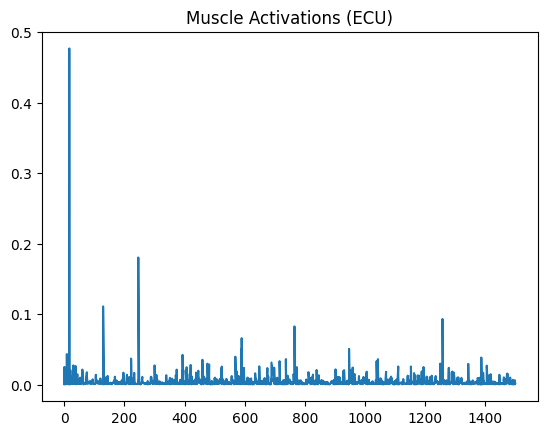

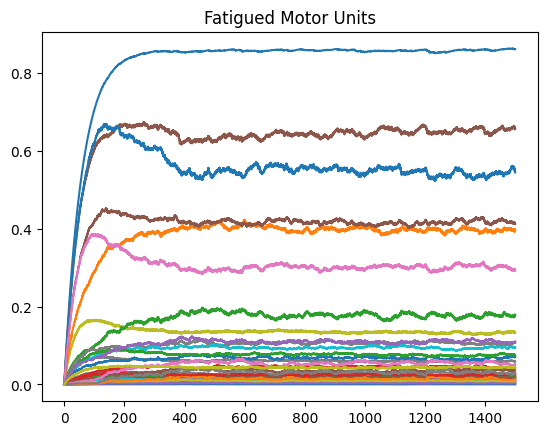

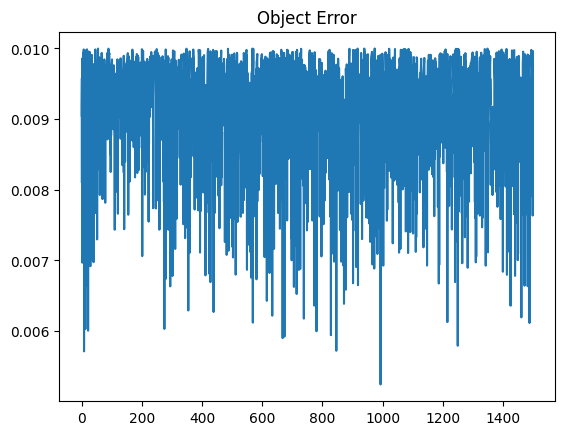

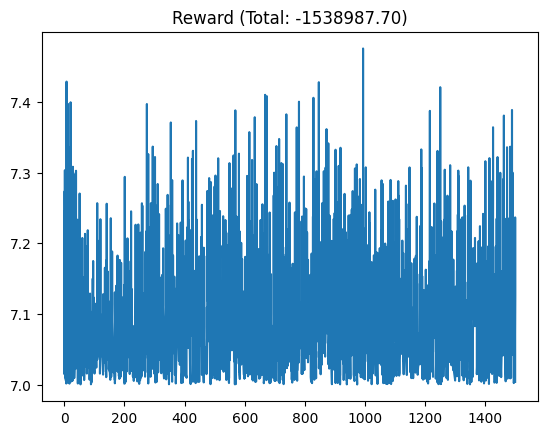

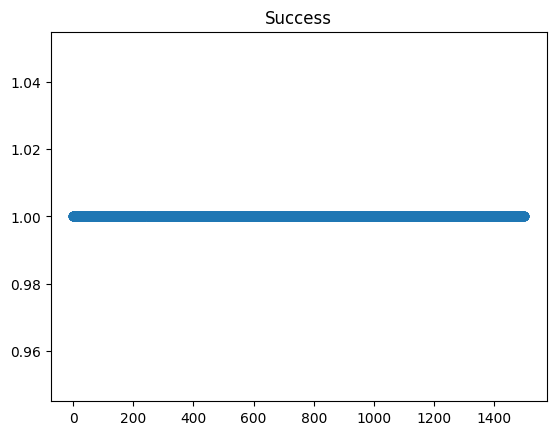

In [21]:
env_name = "myoFatiHandObjHoldFixed-v0"
muscle_id = 2

####################

env_test = gym.make(env_name, normalize_act=False)
muscle_names = [env_test.sim.model.id2name(i, "actuator") for i in range(env_test.sim.model.na)]
_env_dt = env_test.dt  #0.02

data_store = np.load(f"{env_name}/logs/fatitest_trained_wo_fatigue.npy", allow_pickle=True)

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['act'][muscle_id] for d in data_store])[np.array([d['solved'] for d in data_store])])
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['act'][muscle_id] for d in data_store]))
plt.title(f'Muscle Activations ({muscle_names[muscle_id]})')

plt.figure()
for _muscleid in range(len(data_store[0]['MF'])):
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['MF'][_muscleid] for d in data_store]))
plt.title('Fatigued Motor Units')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([np.linalg.norm(d['obj_err']) for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title('Object Error')
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([np.linalg.norm(d['obj_err']) for d in data_store])), plt.title('Object Error')

plt.figure()
if "solved" in data_store[0]:
    plt.plot(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['reward'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")
else:
    plt.plot(_env_dt*np.arange(len(data_store)), np.array([d['reward'] for d in data_store])), plt.title(f"Reward (Total: {np.array([d['reward'] for d in data_store]).sum():.2f})")

if "solved" in data_store[0]:
    plt.figure()
    plt.scatter(_env_dt*np.arange(len(data_store))[np.array([d['solved'] for d in data_store])], np.array([d['solved'] for d in data_store])[np.array([d['solved'] for d in data_store])]), plt.title(f"Success")

print(f"Muscle Fatigue Equilibrium: {data_store[-1]['MF']}")